In [82]:
import torch
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torchvision
from einops import rearrange


In [76]:
# Matrix factorization function with gradient descent
def matrix_factorization(X, rank, learning_rate=0.01, iterations=1000):
    X = X.to(device)
    n, m = X.shape
    W = torch.randn(n, rank, requires_grad=True, device=device)
    H = torch.randn(rank, m, requires_grad=True, device=device)
    
    optimizer = torch.optim.SGD([W, H], lr=learning_rate)
    mask = ~torch.isnan(X)  # Handle NaN values if any

    for i in range(iterations):
        reconstruction = torch.mm(W, H)  # Matrix multiplication
        loss = torch.norm((X - reconstruction)[mask])  # Loss function
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H

# RMSE calculation function
def calculate_rmse(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    original_flat = original.flatten()
    reconstructed_flat = reconstructed.flatten()
    return np.sqrt(mean_squared_error(original_flat, reconstructed_flat))

# PSNR calculation function
def calculate_psnr(original, reconstructed):
    original_flat = original.flatten()
    reconstructed_flat = reconstructed.flatten()
    mse = np.mean((original_flat - reconstructed_flat) ** 2)
    if mse == 0:
        return 100  # No noise in the image
    return 20 * np.log10(255.0 / np.sqrt(mse))


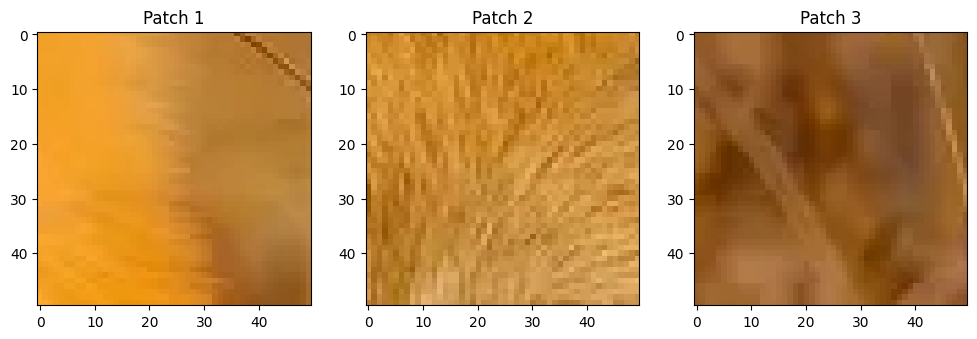

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = torchvision.io.read_image("C:\\Machine Learning\\Assignment_2\\ML.png")  # Replace with your image path

# Crop three 50x50 patches from different locations
patch1 = torchvision.transforms.functional.crop(image, 200, 300, 50, 50)  # Patch 1
patch2 = torchvision.transforms.functional.crop(image, 100, 150, 50, 50)  # Patch 2
patch3 = torchvision.transforms.functional.crop(image, 250, 400, 50, 50)  # Patch 3

# Display the patches for visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(rearrange(patch1, 'c h w -> h w c').numpy())  # Display Patch 1
ax[0].set_title("Patch 1")

ax[1].imshow(rearrange(patch2, 'c h w -> h w c').numpy())  # Display Patch 2
ax[1].set_title("Patch 2")

ax[2].imshow(rearrange(patch3, 'c h w -> h w c').numpy())  # Display Patch 3
ax[2].set_title("Patch 3")

plt.show()


In [78]:
ranks = [5, 10, 25, 50]
patches = [patch1, patch2, patch3]  # List of patches
reconstructed_patches = []

for idx, patch in enumerate(patches):
    print(f"Processing Patch {idx+1}")
    patch_reconstructions = []

    for r in ranks:
        print(f"Factorizing with rank = {r}")
        
        # Factorize each color channel separately
        R_channel = patch[0, :, :]
        G_channel = patch[1, :, :]
        B_channel = patch[2, :, :]

        W_R, H_R = matrix_factorization(R_channel, r)
        W_G, H_G = matrix_factorization(G_channel, r)
        W_B, H_B = matrix_factorization(B_channel, r)

        # Reconstruct each channel
        recon_R = torch.mm(W_R, H_R).detach().cpu().numpy()
        recon_G = torch.mm(W_G, H_G).detach().cpu().numpy()
        recon_B = torch.mm(W_B, H_B).detach().cpu().numpy()

        # Combine the three color channels
        reconstructed_patch = np.array([recon_R, recon_G, recon_B])
        reconstructed_patch = np.clip(reconstructed_patch, 0, 255)
        patch_reconstructions.append(torch.tensor(reconstructed_patch))

    reconstructed_patches.append(patch_reconstructions)


Processing Patch 1
Factorizing with rank = 5
Iteration 0, Loss: 10537.0556640625
Iteration 100, Loss: 10531.078125
Iteration 200, Loss: 10515.2255859375
Iteration 300, Loss: 10404.2080078125
Iteration 400, Loss: 9601.25390625
Iteration 500, Loss: 3834.359375
Iteration 600, Loss: 426.643310546875
Iteration 700, Loss: 412.1907958984375
Iteration 800, Loss: 368.4197998046875
Iteration 900, Loss: 280.5947265625
Iteration 0, Loss: 7019.9462890625
Iteration 100, Loss: 7008.43310546875
Iteration 200, Loss: 6954.869140625
Iteration 300, Loss: 6574.7138671875
Iteration 400, Loss: 3867.839599609375
Iteration 500, Loss: 394.75994873046875
Iteration 600, Loss: 375.6728820800781
Iteration 700, Loss: 330.7125549316406
Iteration 800, Loss: 270.6487121582031
Iteration 900, Loss: 249.75694274902344
Iteration 0, Loss: 2372.736083984375
Iteration 100, Loss: 2346.4306640625
Iteration 200, Loss: 2186.162109375
Iteration 300, Loss: 1188.7115478515625
Iteration 400, Loss: 460.16510009765625
Iteration 500, Lo

In [84]:
rmse_values = []
psnr_values = []


for i, patch in enumerate(patches):
    print(f"Evaluating Patch {i+1}")
    rmse_patch = []
    psnr_patch = []

    for j, rank in enumerate(ranks):
        rmse = calculate_rmse(patch, reconstructed_patches[i][j])
        psnr = calculate_psnr(patch.numpy(), reconstructed_patches[i][j].numpy())
        rmse_patch.append(rmse)
        psnr_patch.append(psnr)
        print(f"Rank {rank}: RMSE = {rmse}, PSNR = {psnr}")

    rmse_values.append(rmse_patch);
    psnr_values.append(psnr_patch);


rmse_df = pd.DataFrame(rmse_values, columns=[f"Rank {rank}" for rank in ranks],
                       index=[f"Patch {i+1}" for i in range(len(patches))])
psnr_df = pd.DataFrame(psnr_values, columns=[f"Rank {rank}" for rank in ranks],
                       index=[f"Patch {i+1}" for i in range(len(patches))])


print("RMSE Table:")
print(rmse_df)

print("\nPSNR Table:")
print(psnr_df)


Evaluating Patch 1
Rank 5: RMSE = 4.877949237823486, PSNR = 34.366058349609375
Rank 10: RMSE = 3.971666097640991, PSNR = 36.15134811401367
Rank 25: RMSE = 2.3551669120788574, PSNR = 40.69036865234375
Rank 50: RMSE = 1.4733221530914307, PSNR = 44.76484680175781
Evaluating Patch 2
Rank 5: RMSE = 11.482690811157227, PSNR = 26.929929733276367
Rank 10: RMSE = 9.933096885681152, PSNR = 28.189109802246094
Rank 25: RMSE = 6.689023494720459, PSNR = 31.623550415039062
Rank 50: RMSE = 2.6037979125976562, PSNR = 39.81865692138672
Evaluating Patch 3
Rank 5: RMSE = 7.545965671539307, PSNR = 30.576507568359375
Rank 10: RMSE = 5.162081718444824, PSNR = 33.874305725097656
Rank 25: RMSE = 2.5267257690429688, PSNR = 40.07964324951172
Rank 50: RMSE = 1.021948218345642, PSNR = 47.942222595214844
RMSE Table:
            Rank 5   Rank 10   Rank 25   Rank 50
Patch 1   4.877949  3.971666  2.355167  1.473322
Patch 2  11.482691  9.933097  6.689023  2.603798
Patch 3   7.545966  5.162082  2.526726  1.021948

PSNR 

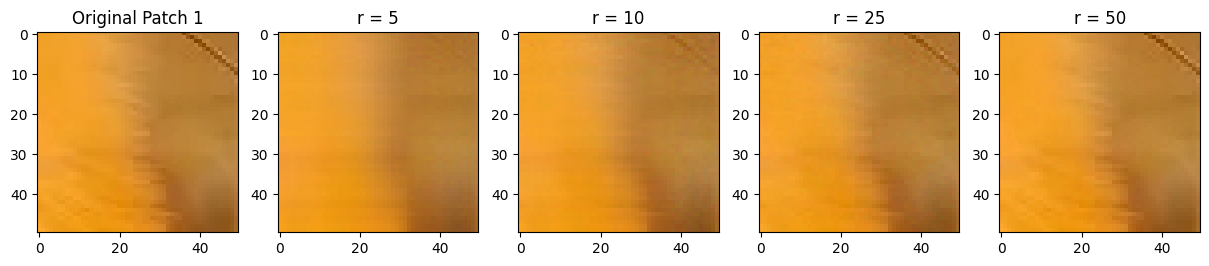

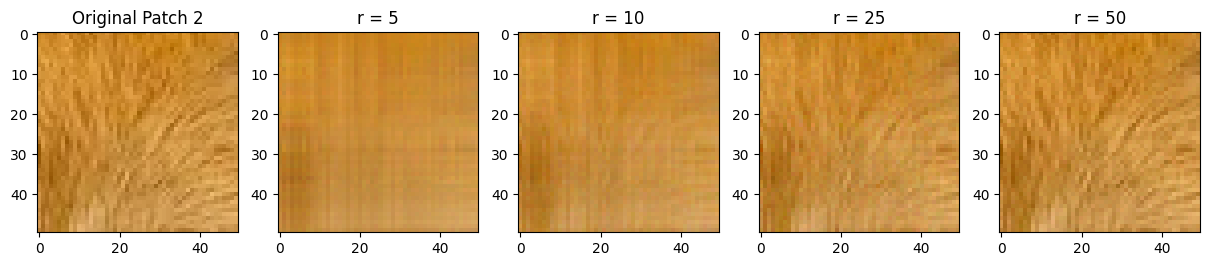

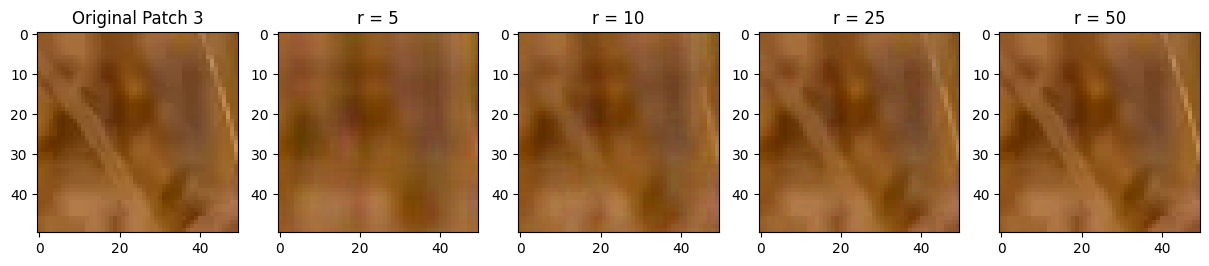

In [80]:
for i, patch in enumerate(patches):
    fig, ax = plt.subplots(1, 5, figsize=(15, 5))
    ax[0].imshow(rearrange(patch, 'c h w -> h w c').numpy().astype(np.uint8))
    ax[0].set_title(f"Original Patch {i+1}")

    for j, rank in enumerate(ranks):
        ax[j+1].imshow(rearrange(reconstructed_patches[i][j], 'c h w -> h w c').numpy().astype(np.uint8))
        ax[j+1].set_title(f"r = {rank}")

    plt.show()


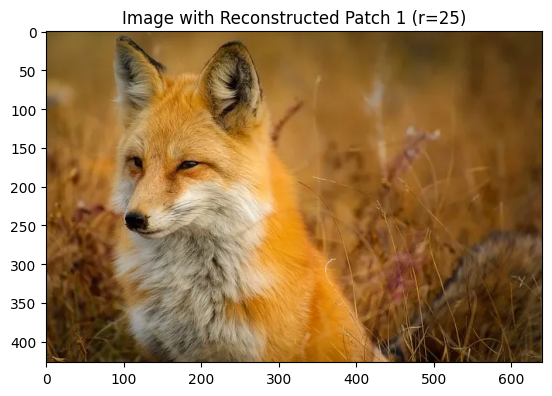

In [81]:
# Replace the patches in the original image (example: replacing patch 1 with rank 25)
x, y = 200, 300  # Coordinates where patch1 was cropped
image_copy = image.clone()
image_copy[:, x:x+50, y:y+50] = reconstructed_patches[0][2]  # Replace with rank = 25 for patch 1

plt.imshow(rearrange(image_copy, 'c h w -> h w c').numpy().astype(np.uint8))
plt.title("Image with Reconstructed Patch 1 (r=25)")
plt.show()
